# Let's import all Libraries 

In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

2024-04-03 13:27:35.594269: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Yestech/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Let's load the dataset and save it

In [3]:
data_source = 'alphavantage' # alphavantage

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = 'BFVHLBYFF0ZKTB84'
    # We will be using the apple stock market price to train our model
    ticker = "AAPL"

    # JSON file with all the stock market data for AAPL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stockmarket_data-%s.csv'%ticker

    
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

File already exists. Loading data from CSV


# Now let's read the data

In [4]:
df=pd.read_csv("stockmarket_data-AAPL.csv")
df = df.sort_values('Date')

# Double check the result
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
6142,0,1999-11-01,77.37,80.69,77.62,80.00
6141,1,1999-11-02,77.31,81.69,80.25,78.00
6140,2,1999-11-03,81.00,83.25,81.50,81.62
6139,3,1999-11-04,80.62,85.37,83.62,82.06
6138,4,1999-11-05,84.00,88.37,88.31,84.62


# We don't need the "unneamed column"

In [5]:
# So let's drop it
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

In [6]:
df.head()

,Date,Low,High,Close,Open
6142,1999-11-01,77.37,80.69,77.62,80.00
6141,1999-11-02,77.31,81.69,80.25,78.00
6140,1999-11-03,81.00,83.25,81.50,81.62
6139,1999-11-04,80.62,85.37,83.62,82.06
6138,1999-11-05,84.00,88.37,88.31,84.62


Let's check the min date and max date

In [7]:
df['Date'].min(), df['Date'].max()

('1999-11-01', '2024-04-02')

We have enough data to play with

In [8]:
# Now let's get the minimum and maximum values for each column
min_max_values = df[['Low', 'High', 'Close', 'Open']].agg(['min', 'max'])

print(min_max_values)

        Low    High   Close    Open
min   12.72   13.19   13.12   12.99
max  699.57  705.07  702.10  702.41


Let's make the date column our index colum because of the following reasons
1. We can easily retrieve the data.
2. Visualization is also simple.
3.These libraries have been designed in such a way that they require a date column as an index (e.g., scipy, statsmodel).

In [9]:
df=df.set_index("Date")
df

,Low,High,Close,Open
Date,,,,
1999-11-01,77.3700,80.69,77.62,80.00
1999-11-02,77.3100,81.69,80.25,78.00
1999-11-03,81.0000,83.25,81.50,81.62
1999-11-04,80.6200,85.37,83.62,82.06
1999-11-05,84.0000,88.37,88.31,84.62
...,...,...,...,...
2024-03-26,169.5800,171.42,169.71,170.00
2024-03-27,170.1100,173.60,173.31,170.41
2024-03-28,170.5100,172.23,171.48,171.75


# Let's do some EDA

Summary Statistics:Calculate summary statistics such as mean, median, mode, and standard deviation to gain insights into the data.

Visualize the Time Series Data: Generate a plot of the Time Series data.

Plot the Rolling Mean and Rolling Standard Deviation:Plot the rolling mean and rolling standard deviation of the Time Series data.

Decompose the Time Series Data: Decompose the Time Series data to identify any trends, seasonality, and noise.

Plot the Decomposed Components:Visualize the decomposed components to gain a deeper understanding of the Time Series data.

Stationarity Check:Examine the stationarity of the Time Series data.

Perform the Augmented Dickey-Fuller Test:Check for stationarity using the Augmented Dickey-Fuller test.

Autocorrelation Check:Plot the autocorrelation function (ACF) to assess autocorrelation within the Time Series data.

In [10]:
#Let's start by describing the data
df.describe()

,Low,High,Close,Open
count,6143.000000,6143.000000,6143.000000,6143.000000
mean,171.434725,175.385112,173.468837,173.462333
std,147.238687,149.891593,148.600946,148.665855
min,12.720000,13.190000,13.120000,12.990000
25%,73.495000,75.225000,74.310250,74.430000
50%,133.770000,137.420000,135.510000,135.900000
75%,195.730000,199.865000,197.775000,197.885000
max,699.570000,705.070000,702.100000,702.410000


## Using Last 5 years data because if we use all 20 years , the code will take too much time to run

In [11]:

df = pd.read_csv('stockmarket_data-AAPL.csv')

# Assuming your dataset has a column named 'Date' containing dates in the format 'YYYY-MM-DD'
# Convert the 'Date' column to datetime if it's not already in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by the 'Date' column in descending order
df.sort_values(by='Date', ascending=False, inplace=True)

# Get the current date
current_date = pd.Timestamp.now().date()

# Calculate the date 5 years ago from the current date
five_years_ago = current_date - pd.DateOffset(years=5)

# Filter the DataFrame to get data from the last 5 years
last_5_years_data = df[df['Date'] >= five_years_ago]

# Print the last 5 years data
last_5_years_data.head()

,Unnamed: 0,Date,Low,High,Close,Open
0,6142,2024-04-02,168.2302,169.34,168.84,169.08
1,6141,2024-04-01,169.4750,171.25,170.03,171.19
2,6140,2024-03-28,170.5100,172.23,171.48,171.75
3,6139,2024-03-27,170.1100,173.60,173.31,170.41
4,6138,2024-03-26,169.5800,171.42,169.71,170.00


Let's drop the "unnamed" column and make the date column our index in our new datatset

In [12]:
# So let's drop it
last_5_years_data = last_5_years_data.drop(columns=['Unnamed: 0'], errors='ignore')

last_5_years_data=last_5_years_data.set_index("Date")

Now let's visualize AAPL prices over time

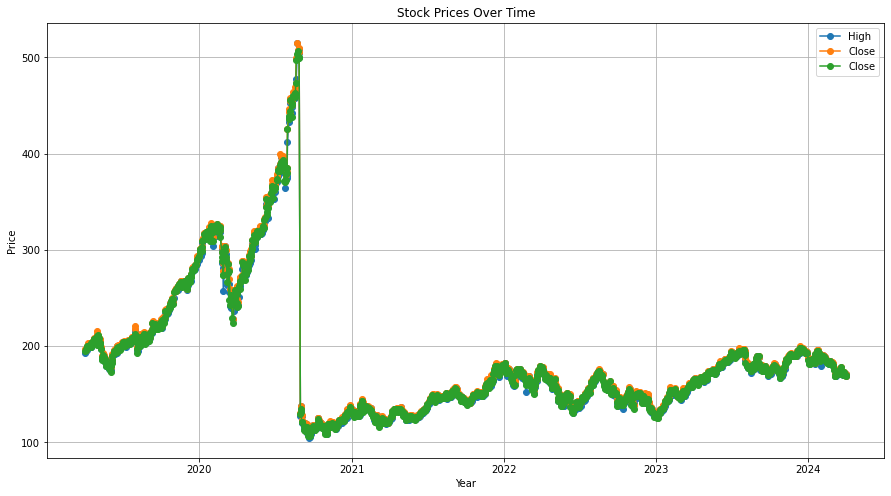

In [13]:
plt.figure(figsize=(15, 8))
plt.plot(last_5_years_data.index, last_5_years_data['Open'], label='High', marker='o')
plt.plot(last_5_years_data.index, last_5_years_data['High'], label='Close', marker='o')
plt.plot(last_5_years_data.index, last_5_years_data['Close'], label='Close', marker='o')

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Observation

The chart provided aggregates stock data by day, resulting in too many data points that might obscure trends and be overly sensitive to outliers, such as extreme fluctuations due to holidays like Christmas. To enhance the clarity of our observations and detect trends more effectively, we can aggregate the data over longer periods of time.

Observation: At the end of the year 2020, the high, low, and close prices of the stock were consistently at or above 550. However, as we transitioned into the beginning of the year 2021, we observed a significant downturn in the stock's performance.

=============================================================

Let's get more insight by creating a 2x2 grid of subplots, each showing the average low, high and close stock price aggregated over different time periods (week, month, quarter, and year). 

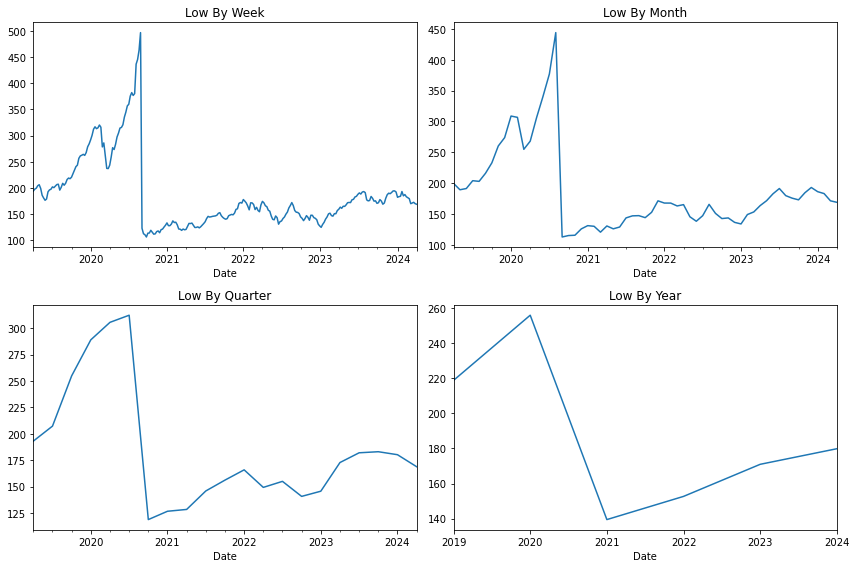

In [14]:
# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

# Group by different time periods and plot
last_5_years_data['Low'].resample('W').mean().plot(ax=ax[0, 0])  # group by week
last_5_years_data['Low'].resample('M').mean().plot(ax=ax[0, 1])  # group by month
last_5_years_data['Low'].resample('Q').mean().plot(ax=ax[1, 0])  # group by quarter
last_5_years_data['Low'].resample('Y').mean().plot(ax=ax[1, 1])  # group by year

# Set titles for each subplot
ax[0, 0].set_title('Low By Week')
ax[0, 1].set_title('Low By Month')
ax[1, 0].set_title('Low By Quarter')
ax[1, 1].set_title('Low By Year')

# Adjust layout and show plot
fig.tight_layout()
plt.show()

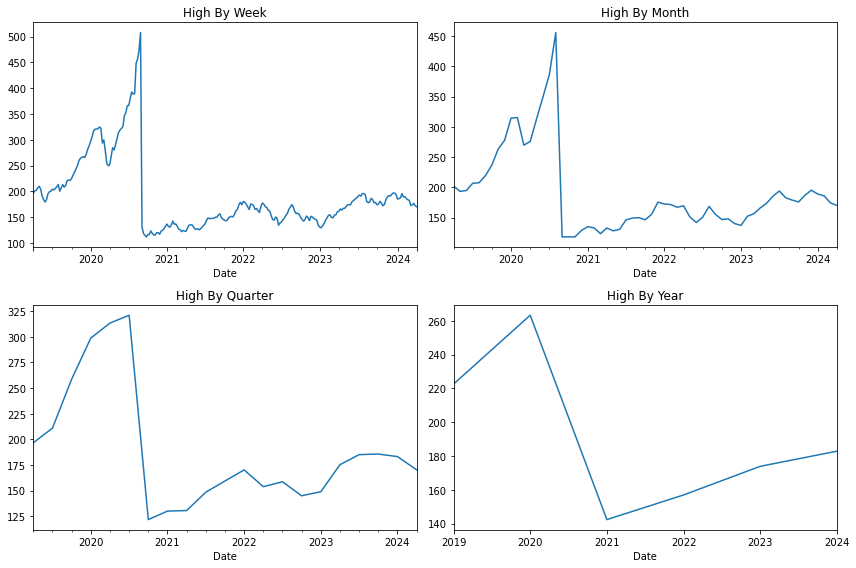

In [15]:
# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

# Group by different time periods and plot
last_5_years_data['High'].resample('W').mean().plot(ax=ax[0, 0])  # group by week
last_5_years_data['High'].resample('M').mean().plot(ax=ax[0, 1])  # group by month
last_5_years_data['High'].resample('Q').mean().plot(ax=ax[1, 0])  # group by quarter
last_5_years_data['High'].resample('Y').mean().plot(ax=ax[1, 1])  # group by year

# Set titles for each subplot
ax[0, 0].set_title('High By Week')
ax[0, 1].set_title('High By Month')
ax[1, 0].set_title('High By Quarter')
ax[1, 1].set_title('High By Year')

# Adjust layout and show plot
fig.tight_layout()
plt.show()

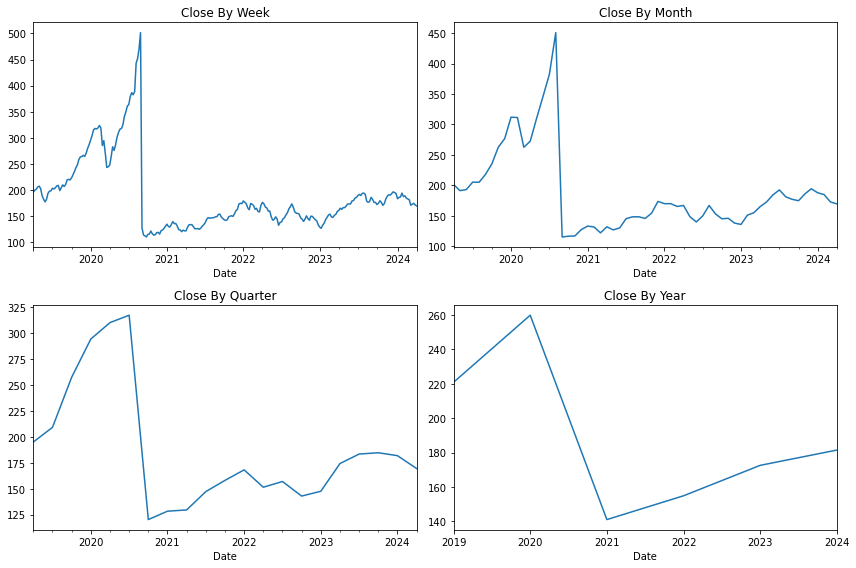

In [16]:
# Create subplots for 'Close'
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

last_5_years_data['Close'].resample('W').mean().plot(ax=ax[0, 0])  # group by week
last_5_years_data['Close'].resample('M').mean().plot(ax=ax[0, 1])  # group by month
last_5_years_data['Close'].resample('Q').mean().plot(ax=ax[1, 0])  # group by quarter
last_5_years_data['Close'].resample('Y').mean().plot(ax=ax[1, 1])  # group by year

ax[0, 0].set_title('Close By Week')
ax[0, 1].set_title('Close By Month')
ax[1, 0].set_title('Close By Quarter')
ax[1, 1].set_title('Close By Year')

fig.tight_layout()
plt.show()

# Observation

Upon examining the graphs, it's evident that between 2020 and 2021, there was a notable surge in the stock price across all timeframes. This spike suggests a period of increased market activity or favorable conditions for the stock. However, following this peak, the stock's performance became considerably erratic.

# Let's try seasonal decomposition

Utilizing the seasonal_decompose function is another valuable technique in our analytical arsenal for time series data. This function disassembles the time series into distinct components.

1. Observed: This component represents the raw time series data as observed, capturing the inherent patterns and fluctuations.

2. Trend: The observed trend within the data, showcasing the long-term direction or tendency of the series.

3. Seasonal: This component highlights the repetitive patterns or seasonality present in the data, such as daily, weekly, or yearly fluctuations.

4. Residual: The residual component represents what remains once the trend and seasonal components have been extracted. It encapsulates the irregular or unpredictable fluctuations in the data.

In an ideal scenario, after accounting for trends and seasonality, the residuals should exhibit consistent behavior over time. Any deviation from this consistency could indicate the presence of underlying factors or patterns not captured by the trend or seasonal components. Analyzing these residuals can provide insights into unexpected changes or anomalies within the data, aiding in decision-making and forecasting processes.

<Figure size 1152x864 with 0 Axes>

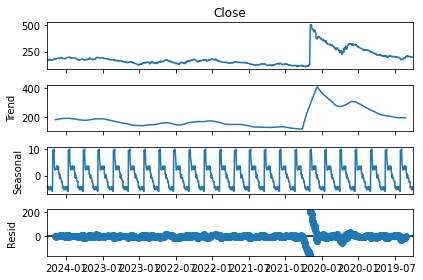

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply seasonal decomposition to the 'Close' column of df
decompose = seasonal_decompose(last_5_years_data['Close'], period=52)

# Plot the seasonal decomposition
fig = plt.figure(figsize=(16, 12))
fig = decompose.plot()
plt.show()

<Figure size 1152x648 with 0 Axes>

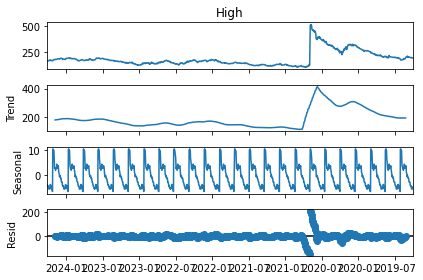

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply seasonal decomposition to the 'Close' column of df
decompose = seasonal_decompose(last_5_years_data['High'], period=52)

# Plot the seasonal decomposition
fig = plt.figure(figsize=(16, 9))
fig = decompose.plot()
plt.show()

<Figure size 1152x648 with 0 Axes>

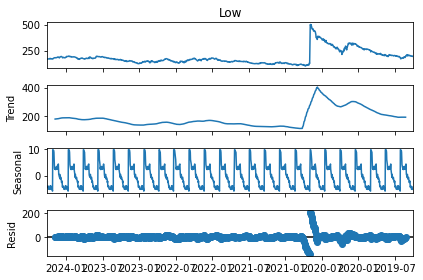

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply seasonal decomposition to the 'Close' column of df
decompose = seasonal_decompose(last_5_years_data['Low'], period=52)

# Plot the seasonal decomposition
fig = plt.figure(figsize=(16, 9))
fig = decompose.plot()
plt.show()

In time series analysis, 'stationary' refers to a series whose statistical properties, such as mean, variance, and autocorrelation structure, remain constant over time. A stationary series exhibits consistent patterns and is easier to model and predict.
On the other hand, a series that is 'non-stationary' displays trends, seasonality, or other patterns that change over time, leading to variations in its statistical properties. Non-stationary series often require transformations, such as differencing or detrending, to make them stationary before applying time series models. This transformation helps stabilize the series' statistical properties, making it suitable for analysis and modeling.

Based on the above observations, it is clear that our data is not stationary. 

===================================================================================

We are now going to use the "Close" column to make futher analysis and come to a conclusion

## Rationale for Using Only the Closing Price Column

The closing price of a stock holds significant importance for several reasons:

1. Reflects Market Sentiment: The closing price encapsulates all available information and news up to the end of the trading day. As such, it is often considered a reliable reflection of the overall market sentiment for that day.

2. Liquidity: Trades executed near the end of the trading day typically involve higher liquidity compared to other times, ensuring that the closing price is based on a more substantial volume of transactions. This higher liquidity enhances the reliability of the closing price as an indicator of the stock's value.

3. Consistency: Unlike the 'Open' price, which can be influenced by pre-market or after-hours trading, the closing price is standardized and consistent across different time periods or stocks. This consistency facilitates meaningful comparisons and analyses.

4. Technical Analysis: In technical analysis, the closing price is widely utilized to calculate various indicators and patterns, such as moving averages and support/resistance levels. These technical tools aid in predicting future price movements and identifying potential trading opportunities.

5. Modeling Stability: Focusing solely on the closing price can lead to more stable and robust models. By mitigating the impact of intraday fluctuations and noise present in the 'Open', 'High', or 'Low' prices, models built on closing prices tend to exhibit greater stability and reliability over time.

By emphasizing the significance and advantages of the closing price, we can ensure that our analysis is anchored in reliable and meaningful data, thereby enhancing the effectiveness of our modeling and decision-making processes.

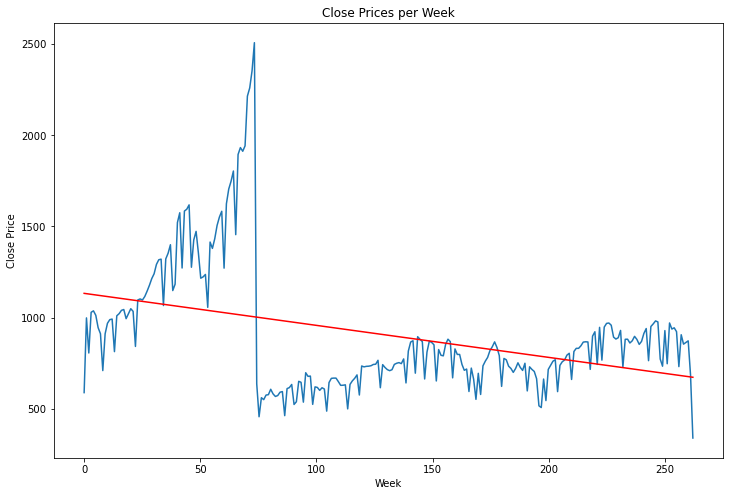

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'Date' is the index column in df
sales_by_week = last_5_years_data['Close'].resample('w').sum()  # Create dataframe showing close prices by week

data_points = np.linspace(0, len(sales_by_week), num=len(sales_by_week))  # Create list of data points

line_coef = np.polyfit(data_points, sales_by_week, 1)  # Find trendline of weekly close prices

polynomial = np.poly1d(line_coef)  # Function for returning dependent variable

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data_points, sales_by_week)
ax.plot(data_points, polynomial(data_points), c='red')
ax.set_title('Close Prices per Week')
ax.set_ylabel('Close Price')
ax.set_xlabel('Week')
plt.show()

There is a fluctuation in price

### Identify Trends - Using Rolling 

Rolling statistics involve applying statistical measures (e.g., rolling mean, rolling standard deviation) to a time series over a moving window of data points. This is often done to smooth out short-term fluctuations and highlight longer-term trends or patterns.
- Rolling statistics help in identifying patterns and trends within the data, especially when there is seasonality or cyclic behavior. They are useful for understanding the inherent structure of the time series.
- Rolling statistics do not necessarily remove trends or seasonality from the data; instead, they provide a smoothed representation that makes it easier to visualise and analyse these components.

The technique involves grouping a given number (e.g. 3) observations together and calculating an aggregate (e.g. mean). We then move the process forward one observation and calculate the aggregate again.

To give an example, in a week our first 'window' would be Monday, Tuesday and Wednesday. The second 'window' would be Tuesday, Wednesday and Thursday. The third would be Wednesday, Thursday and Friday and so on. 

Rolling values allow us to see how the data is behaving through moving windows, and can be far more informative than looking at the raw data. Looking at each data point individually is risky, as this allows for daily anomalies to have a large effect. Instead, by grouping dates together we can more easily ignore outliers and see what the overall trend is. For example, during parts of the year where you would expect higher sales (e.g. Christmas) it is useful to see how sales are performing over a group of days, which can then be compared to each other. 

To calculate rolling statistics we need to supply two inputs- 

<ul>
    <li><b>window</b> - how many observations to include </li>
    <li><b>center</b> - set to True if you want the window to center on the date for that observation</li>
</ul>

<table>
    <tr>
        <th> <code> center = True </code></th>
        <th> <code> center = False </code></th>
    </tr>
    <tr>
        <td> Monday, <b> Tuesday </b>, Wednesday </td>
        <td> Monday, Tuesday, <b> Wednesday </b> </td>
    </tr>
</table>

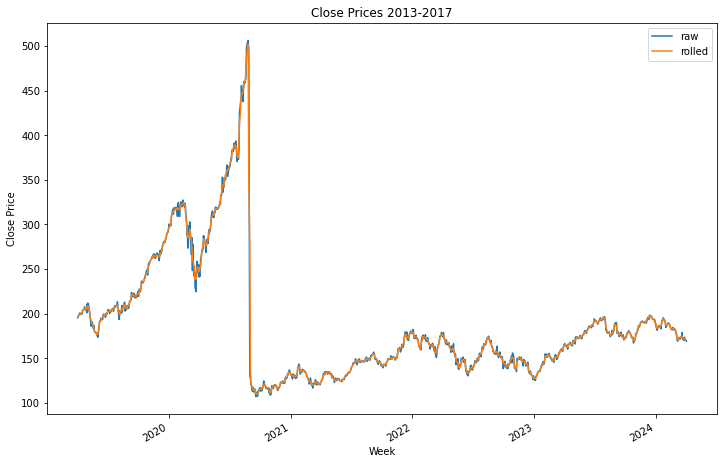

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
last_5_years_data['Close'].plot(ax=ax, label='raw')
last_5_years_data['Close'].rolling(window=5, center=True).mean().plot(ax=ax, label='rolled')
ax.set_title('Close Prices 2013-2017')
ax.set_ylabel('Close Price')
ax.set_xlabel('Week')
plt.legend()
plt.show()

The trend has become smoother as a result of the rolling process, which effectively filters out daily variations, thereby enhancing clarity in trend identification. Furthermore, outliers have been addressed, with their influence minimized. Utilizing rolling statistics is particularly beneficial for data sets containing outliers or exhibiting noticeable trends, as it aids in mitigating their impact.

# Now let train our model using LSTM and Markov and make predictions

In [2]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
from alpha_vantage.timeseries import TimeSeries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

class LSTMModel:
    def __init__(self, scaler=None):
        self.model = None
        if scaler is None:
            self.scaler = MinMaxScaler()
        else:
            self.scaler = scaler

    def fit(self, X_train, y_train):
        # Flatten the input data
        X_train_flat = X_train.reshape(-1, X_train.shape[-1])

        # Fit the scaler with training data
        self.scaler.fit(X_train_flat)

        # Build and train the LSTM model
        self.model = Sequential()
        self.model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 4)))
        self.model.add(LSTM(units=50))
        self.model.add(Dense(units=1, activation='sigmoid'))  # Use sigmoid activation for output layer

        self.model.compile(optimizer='adam', loss='mean_squared_error')
        self.model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=2)

    def predict_next_movement(self, last_window):
        # Transform the input data using the fitted scaler
        scaled_X = self.scaler.transform(last_window.reshape(-1, last_window.shape[-1]))

        # Make predictions with the LSTM model
        predicted_movement = self.model.predict(scaled_X.reshape((1, 60, 4)))
        
        # Adjust rounding to ensure predictions are within the range of -1, 0, and 1
        if predicted_movement < 0.33:
            return -1
        elif predicted_movement > 0.67:
            return 1
        else:
            return 0
        
class MarkovModel:
    def __init__(self, order=1):
        self.order = order
        self.transitions = None
        self.classes = None

    def fit(self, data):
        # Discretize the 'Close' column into three categories: Low, Medium, High
        close_prices = data['4. close'].values
        bins = [np.min(close_prices), np.percentile(close_prices, 33), np.percentile(close_prices, 67), np.max(close_prices)]
        discretized_prices = np.digitize(close_prices, bins=bins) - 1
        
        # Initialize transition matrix and classes
        self.classes = np.unique(discretized_prices)
        n_classes = len(self.classes)
        self.transitions = np.zeros((n_classes, n_classes))
        
        # Compute transition counts
        for i in range(len(discretized_prices) - self.order):
            current_state = discretized_prices[i]
            next_state = discretized_prices[i + 1]
            self.transitions[current_state, next_state] += 1
        
        # Normalize transition matrix
        self.transitions = self.transitions / np.sum(self.transitions, axis=1, keepdims=True)
        print("Transition Matrix:", self.transitions)  # Add this line

    def predict_next_movement(self, current_movement):
        if self.transitions is None:
            raise RuntimeError("Model has not been trained yet.")
        
        current_state = np.where(self.classes == current_movement)[0][0]
        next_state_probs = self.transitions[current_state]
        next_movement_index = np.argmax(next_state_probs)
        next_movement = self.classes[next_movement_index]
        
        return next_movement

def determine_action(predicted_movement):
    if predicted_movement == 0:
        return "Sell"
    elif predicted_movement == 1:
        return "Hold"
    elif predicted_movement == 2:
        return "Buy"

def fetch_stock_data(symbol,outputsize='compact'):
    api_key = 'BFVHLBYFF0ZKTB84'  # Replace with your Alpha Vantage API key
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=symbol, outputsize=outputsize)
    return data

def preprocess_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values)
    return scaled_data

def on_predict():
    try:
        symbol = symbol_var.get()
        selected_model = model_var.get()

        # Fetch stock price data
        price_data = fetch_stock_data(symbol)

        # Preprocess data
        scaled_data = preprocess_data(price_data[['1. open', '2. high', '3. low', '4. close']].iloc[::-1])

        # Get last 60 days' data
        last_window = scaled_data[-60:]

        if selected_model == "LSTM":
            # Predict next movement with LSTM model
            lstm_predicted_movement = lstm_model.predict_next_movement(last_window)
            lstm_action = determine_action(lstm_predicted_movement)
            label_lstm_predicted_movement.config(text=f"LSTM Predicted Movement: {lstm_predicted_movement}")
            label_lstm_action.config(text=f"LSTM Action to take: {lstm_action}")

            # Reset Markov model labels
            label_markov_predicted_movement.config(text="")
            label_markov_action.config(text="")
        elif selected_model == "Markov":
            # Predict next movement with Markov model
            price_movements = np.sign(price_data['4. close'].diff().dropna().values)
            markov_model = MarkovModel()
            markov_model.fit(price_movements)
            current_movement = price_movements[-1]
            markov_predicted_movement = markov_model.predict_next_movement(current_movement)
            markov_action = determine_action(markov_predicted_movement)
            label_markov_predicted_movement.config(text=f"Markov Predicted Movement: {markov_predicted_movement}")
            label_markov_action.config(text=f"Markov Action to take: {markov_action}")

            # Reset LSTM model labels
            label_lstm_predicted_movement.config(text="")
            label_lstm_action.config(text="")

        # Display open, high, low, and close prices
        open_price = price_data['1. open'].iloc[-1]
        high_price = price_data['2. high'].iloc[-1]
        low_price = price_data['3. low'].iloc[-1]
        close_price = price_data['4. close'].iloc[-1]

        label_prices.config(text=f"Open: {open_price}, High: {high_price}, Low: {low_price}, Close: {close_price}")

    except Exception as e:
        messagebox.showerror("Error", str(e))


# Sample usage of LSTMModel
symbol_for_training = 'AAPL'
training_data = fetch_stock_data(symbol_for_training, outputsize='full')
scaled_training_data = preprocess_data(training_data[['1. open', '2. high', '3. low', '4. close']])
X_train = scaled_training_data[:-1]  # Use all but the last data point for training
y_train = scaled_training_data[1:, 3]  # Predict the next day's closing price
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))  # Reshape data for LSTM input

lstm_model = LSTMModel()
lstm_model.fit(X_train, y_train)

# Sample usage of Markov Model
symbol_for_training = 'AAPL'
training_data = fetch_stock_data(symbol_for_training)

# Create GUI
root = tk.Tk()
root.title("Stock Prediction")
root.geometry("600x300")

label_symbol = tk.Label(root, text="Select Stock Symbol:")
label_symbol.pack()
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']  # Example list of symbols
symbol_var = tk.StringVar()
symbol_dropdown = ttk.Combobox(root, textvariable=symbol_var, values=symbols)
symbol_dropdown.pack()

label_model = tk.Label(root, text="Select Model:")
label_model.pack()
model_var = tk.StringVar()
model_dropdown = ttk.Combobox(root, textvariable=model_var, values=["LSTM", "Markov"])
model_dropdown.pack()

button_predict = tk.Button(root, text="Predict", command=on_predict)
button_predict.pack()

label_prices = tk.Label(root, text="")
label_prices.pack()

label_lstm_predicted_movement = tk.Label(root, text="")
label_lstm_predicted_movement.pack()

label_lstm_action = tk.Label(root, text="")
label_lstm_action.pack()

label_markov_predicted_movement = tk.Label(root, text="")
label_markov_predicted_movement.pack()

label_markov_action = tk.Label(root, text="")
label_markov_action.pack()

root.mainloop()

ValueError: Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.